In [23]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle
!ls -a ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists
.  ..  kaggle.json


In [24]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split


In [25]:
!kaggle datasets download -d jangedoo/utkface-new
!unzip utkface-new.zip

Streaming output truncated to the last 5000 lines.
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104204327

In [26]:
width = height = 224
batch_size = 32

In [27]:
images = [] # X
ages = [] # Y

for image_name in os.listdir("/content/crop_part1"):
  age = int(image_name.split("_")[0])
  ages.append(age)

  image = cv2.imread(f"/content/crop_part1/{image_name}")
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image, (width, height))
  images.append(image)

In [28]:
images = pd.Series(images, name='Images')
ages = pd.Series(ages, name='Ages')

dataframe = pd.concat([images, ages], axis=1)
dataframe.head()

,Images,Ages
0,"[[[130, 95, 65], [128, 93, 63], [123, 88, 58],...",40
1,"[[[98, 87, 69], [95, 83, 66], [89, 79, 62], [8...",3
2,"[[[114, 101, 85], [108, 95, 79], [99, 87, 72],...",37
3,"[[[102, 84, 70], [97, 79, 65], [102, 85, 69], ...",3
4,"[[[72, 59, 53], [70, 57, 51], [66, 54, 48], [6...",16


40


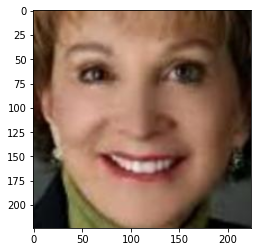

In [29]:
print(dataframe['Ages'][0])
plt.imshow(dataframe['Images'][0])
plt.show()

3


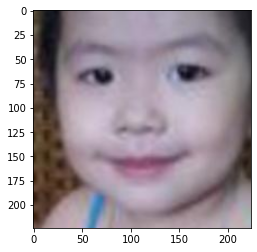

In [30]:
print(dataframe["Ages"][1])
plt.imshow(dataframe["Images"][1])
plt.show()

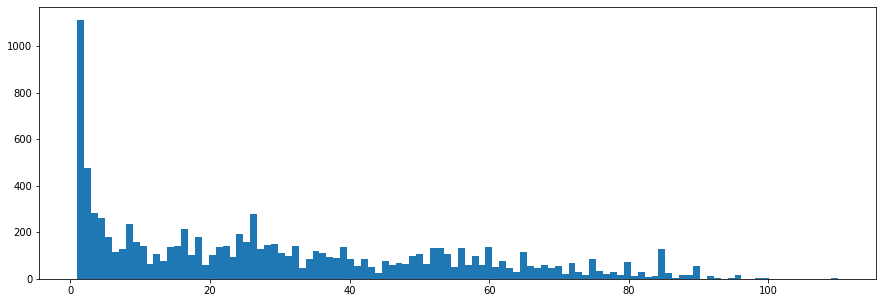

In [32]:
plt.figure(figsize=(15, 5))
plt.hist(dataframe['Ages'], bins=dataframe['Ages'].max())
plt.show()

In [33]:
under_4 = dataframe[dataframe["Ages"] <= 4]
under_4_new = under_4.sample(frac=0.3)

up_4 = dataframe[dataframe["Ages"] > 4]

dataframe = pd.concat([under_4_new, up_4], axis=0)

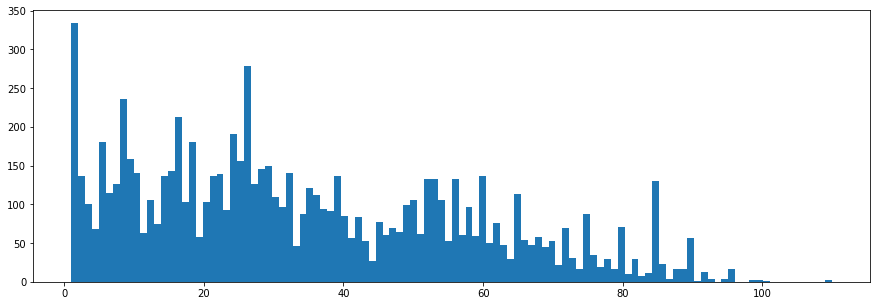

In [34]:
plt.figure(figsize=(15, 5))
plt.hist(dataframe['Ages'], bins=dataframe['Ages'].max())
plt.show()

In [35]:
dataframe = dataframe[dataframe["Ages"] < 80]

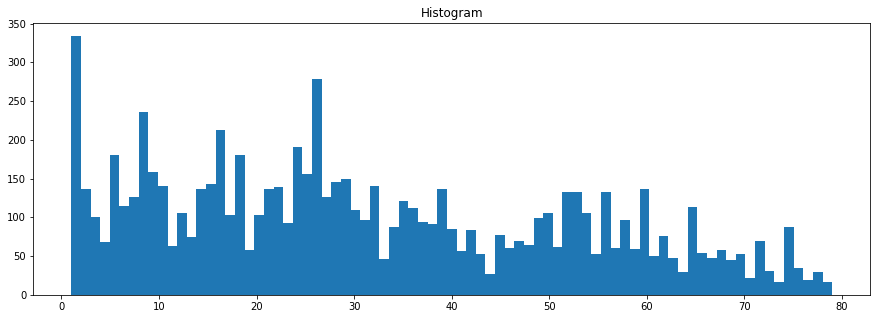

In [36]:
plt.figure(figsize=(15, 5))
plt.hist(dataframe["Ages"], bins=dataframe["Ages"].max())
plt.title("Histogram")
plt.show()

In [37]:
X = np.array(dataframe['Images'].values.tolist())
Y = np.array(dataframe['Ages'].values.tolist())

In [38]:
print(X.shape)
print(Y.shape)

(7871, 224, 224, 3)
(7871,)


In [39]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1)

print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)


(7083, 224, 224, 3)
(7083,)
(788, 224, 224, 3)
(788,)


In [40]:
idg = ImageDataGenerator(rescale=1./255,
                         horizontal_flip=True,
                         )

train_data = idg.flow(X_train, Y_train, batch_size=batch_size)
val_data = idg.flow(X_val, Y_val, batch_size=batch_size)

In [41]:
base_model = tf.keras.applications.Xception(
    input_shape = (width, height, 3),
    weights='imagenet',
    include_top=False,
    pooling='avg'
)

83697664/83683744 [==============================] - 1s 0us/step


In [42]:
for layer in base_model.layers[:-4]:
  layer.trainable = False

In [43]:
model = tf.keras.Sequential([
                             base_model,
                             Dropout(0.5),
                             Dense(1)
])

In [44]:
model.compile(optimizer=Adam(),
              loss=tf.keras.losses.mse)

In [45]:
model.fit(train_data, 
          validation_data=val_data, 
          epochs=25,
          shuffle=True)


Epoch 1/25
222/222 [==============================] - 99s 364ms/step - loss: 348.3120 - val_loss: 146.7129
Epoch 2/25
222/222 [==============================] - 78s 350ms/step - loss: 135.1001 - val_loss: 130.1786
Epoch 3/25
222/222 [==============================] - 78s 350ms/step - loss: 120.7460 - val_loss: 125.0459
Epoch 4/25
222/222 [==============================] - 78s 350ms/step - loss: 111.8246 - val_loss: 128.2924
Epoch 5/25
222/222 [==============================] - 78s 350ms/step - loss: 104.4413 - val_loss: 131.0419
Epoch 6/25
222/222 [==============================] - 78s 350ms/step - loss: 93.2484 - val_loss: 129.4503
Epoch 7/25
222/222 [==============================] - 78s 350ms/step - loss: 92.1272 - val_loss: 122.8912
Epoch 8/25
222/222 [==============================] - 78s 350ms/step - loss: 86.4779 - val_loss: 119.3301
Epoch 9/25
222/222 [==============================] - 78s 350ms/step - loss: 81.3420 - val_loss: 107.5825
Epoch 10/25
222/222 [====================

In [48]:
def inference(img_path):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img)
  plt.show()
  img = img / 255.0
  img = cv2.resize(img, (width, height))
  img = img.reshape(1, width, height, 3)
  pred = model.predict(img)
  pred = pred[0, 0]
  return pred

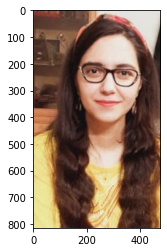

33.904705

In [54]:
inference("/content/photo1648645948.jpeg")

In [55]:
model.save("/content/drive/MyDrive/Age_diagnosis.h5")